<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/master/EVA4S5_suman_code5_LRScheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True



# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [5]:
'''
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
'''

"\n# We'd need to convert it into Numpy! Remember above we have converted it into tensors already\ntrain_data = train.train_data\ntrain_data = train.transform(train_data.numpy())\n\nprint('[Train]')\nprint(' - Numpy Shape:', train.train_data.cpu().numpy().shape)\nprint(' - Tensor Shape:', train.train_data.size())\nprint(' - min:', torch.min(train_data))\nprint(' - max:', torch.max(train_data))\nprint(' - mean:', torch.mean(train_data))\nprint(' - std:', torch.std(train_data))\nprint(' - var:', torch.var(train_data))\n\ndataiter = iter(train_loader)\nimages, labels = dataiter.next()\n\nprint(images.shape)\nprint(labels.shape)\n\n# Let's visualize some of the images\n%matplotlib inline\nimport matplotlib.pyplot as plt\n\nplt.imshow(images[0].numpy().squeeze(), cmap='gray_r')\n"

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

In [6]:
'''figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
'''

"figure = plt.figure()\nnum_of_images = 60\nfor index in range(1, num_of_images + 1):\n    plt.subplot(6, 10, index)\n    plt.axis('off')\n    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')\n"

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drpout = nn.Dropout(0.16)

        self.layer1 = nn.Sequential(
            nn.Conv2d(1,8,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #drpout
        )# OP-26   RF-3
        self.layer2 = nn.Sequential(
            nn.Conv2d(8,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            drpout
        ) # OP-24  RF-5
        self.layer3_MP= nn.MaxPool2d(2,2) #OP-12  RF-6
        self.layer4 = nn.Sequential(		
            nn.Conv2d(16,8,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            #drpout
        ) # OP-10	RF-10
        
        self.layer5 = nn.Sequential(		
            nn.Conv2d(8,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #drpout
        ) # OP-8  RF-14
        self.layer6 = nn.Sequential(
            nn.Conv2d(16,16,3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #drpout
        ) # OP-6  RF-18
        self.layer7 = nn.Sequential(
            nn.Conv2d(16,16,3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            drpout
        ) #op-4 RF-22

        self.layer8 = nn.Sequential(
            nn.Conv2d(16,10,1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
            #drpout
        ) #op-4 RF-22
        self.gap = nn.Sequential(
           nn.AvgPool2d(kernel_size=4)
        )
        '''
        self.layer9 = nn.Sequential(
            # Last-1 layer
            nn.Conv2d(10,10,4,bias=False)
            #nn.ReLU()
        )#op-1 RF-28'''

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3_MP(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.gap(x)
        #x = self.layer9(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 10, 10]           1,152
             ReLU-11            [-1, 8, 10, 10]               0
      BatchNorm2d-12            [-1, 8, 10, 10]              16
           Conv2d-13             [-1, 16, 8, 8]           1,152
             ReLU-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [10]:

from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.005)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.13678163290023804 Batch_id=468 Accuracy=93.79: 100%|██████████| 469/469 [00:12<00:00, 44.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.07790951430797577 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:12<00:00, 37.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.1052127480506897 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


Loss=0.025175198912620544 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.014521119184792042 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:11<00:00, 39.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.02890298329293728 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.030315259471535683 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:11<00:00, 46.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.036404214799404144 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9892/10000 (98.92%)

EPOCH: 9


Loss=0.04938705265522003 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.015294318087399006 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:11<00:00, 43.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.12845180928707123 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.05599848926067352 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.012818020768463612 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 39.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.022151798009872437 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 15


Loss=0.022097362205386162 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 39.04it/s]



Test set: Average loss: 0.0269, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

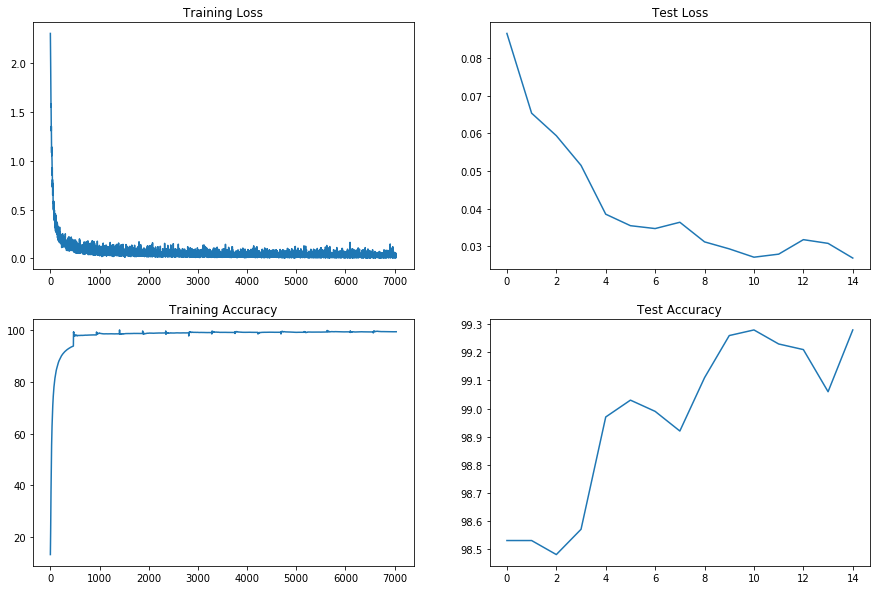

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")